<a href="https://colab.research.google.com/github/Muzsek/One_Number/blob/main/O_N_AIO_cnn%3F%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install captcha

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 9.2 MB/s eta 0:00:00


In [126]:
import string
from captcha.image import ImageCaptcha
import random
import os
from pathlib import Path
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

In [ ]:
drive.mount("/content/drive")

In [19]:
# !ls /content/drive/MyDrive/Colab/One\ Number/
dir_path = Path("/content/drive/MyDrive/Colab/One Number")
dir_path
training_folder = dir_path / "training"
testing_folder = dir_path / "testing"
os.makedirs(training_folder, exist_ok = True)
os.makedirs(testing_folder, exist_ok = True)

In [ ]:
chars = string.digits

img = ImageCaptcha(width = 120,
                    height = 50)
for i in range(int(1000*0.8)):
  label = ''.join(random.choices(chars))
  image = img.generate_image(label)
  image.save(training_folder / f"{label}_{i}.png")

for i in range(int(1000*0.2)):
  label = ''.join(random.choices(chars))
  image = img.generate_image(label)
  image.save(testing_folder / f"{label}_{i}.png")
print(f"{len(os.listdir(os.path.join(training_folder)))} training images created")
print(f"{len(os.listdir(os.path.join(testing_folder)))} testing images created")

800 training images created
200 testing images created


In [ ]:
#!rm -rf /content/drive/MyDrive/Colab/One Number/training/*
#!rm -rf /content/drive/MyDrive/Colab/One Number/testing/*

In [4]:
print(len(os.listdir(training_folder)))
print(f"First 10 files: {os.listdir(training_folder)[:10]}")
print(len(os.listdir(testing_folder)))
print(f"First 10 files: {os.listdir(testing_folder)[:10]}")

800
First 10 files: ['4_0.png', '1_1.png', '5_2.png', '7_3.png', '9_4.png', '9_5.png', '3_6.png', '5_7.png', '3_8.png', '3_9.png']
200
First 10 files: ['4_0.png', '0_1.png', '6_2.png', '9_3.png', '2_4.png', '7_5.png', '4_6.png', '7_7.png', '3_8.png', '7_9.png']


In [5]:
def ShowImage(image_path):
  image = Image.open(image_path)
  plt.imshow(image)
  plt.axis("off")
  plt.show()

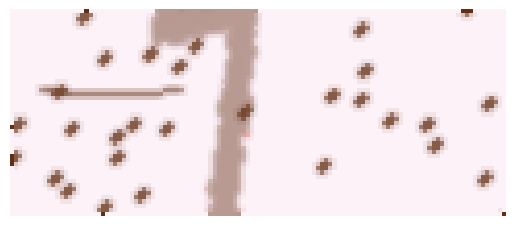

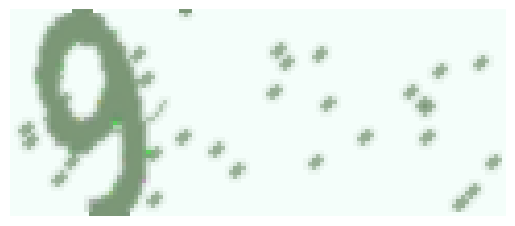

In [6]:
ShowImage(training_folder / os.listdir(training_folder)[3])
ShowImage(testing_folder / os.listdir(testing_folder)[3])

In [125]:
# Making the first_image form PIL to a tensor
first_image = Image.open(training_folder / os.listdir(training_folder)[0])
first_image.size

(120, 50)

In [17]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
first_image_tensor = data_transform(first_image)
first_image_tensor.shape

torch.Size([3, 50, 120])

In [22]:
#os.listdir(training_folder)

In [98]:
training_data = list(training_folder.glob("*.png"))
testing_data = list(testing_folder.glob("*.png"))
print(f"{len(training_data)}\n{len(testing_data)}\n{training_data[:3]}\n{testing_data[:3]}")

800
200
[PosixPath('/content/drive/MyDrive/Colab/One Number/training/4_0.png'), PosixPath('/content/drive/MyDrive/Colab/One Number/training/1_1.png'), PosixPath('/content/drive/MyDrive/Colab/One Number/training/5_2.png')]
[PosixPath('/content/drive/MyDrive/Colab/One Number/testing/4_0.png'), PosixPath('/content/drive/MyDrive/Colab/One Number/testing/0_1.png'), PosixPath('/content/drive/MyDrive/Colab/One Number/testing/6_2.png')]


In [94]:
class CustomDataset(Dataset):
  def __init__(self,image_paths,transform):
    self.image_paths = image_paths
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    image_paths = self.image_paths[index]
    image = Image.open(image_paths).convert('RGB')
    label_str = image_paths.stem.split("_")[0]
    label = int(label_str)
    return self.transform(image),label

4

In [100]:
training_dataset = CustomDataset(training_data, transform = data_transform)
testing_dataset = CustomDataset(testing_data, transform = data_transform)

In [109]:
for _ in range(3):
  print(training_dataset[_][1])
print()
for _ in range(3):
  print(testing_dataset[_][1])

4
1
5

4
0
6


In [113]:
training_loader = DataLoader(training_dataset, batch_size = 32, shuffle = True)
testing_loader = DataLoader(testing_dataset, batch_size = 32, shuffle = False)

In [117]:
dl_test_images, dl_test_labels = next(iter(training_loader))
print(dl_test_images.shape)
print(dl_test_labels.shape)
dl_test_images, dl_test_labels = next(iter(testing_loader))
print(dl_test_images.shape)
print(dl_test_labels.shape)

torch.Size([32, 3, 50, 120])
torch.Size([32])
torch.Size([32, 3, 50, 120])
torch.Size([32])


In [118]:
images, labels = next(iter(training_loader))
print("Train label min/max:", labels.min().item(), labels.max().item())
images_t, labels_t = next(iter(testing_loader))
print("Test label min/max:", labels_t.min().item(), labels_t.max().item())

Train label min/max: 0 9
Test label min/max: 0 9


In [153]:
num_classes = range(9)
num_classes

range(0, 9)

In [159]:
class CNN(nn.Module):
  def __init__(self, in_channels: int, out_channels: int,output_shape: int):
    super().__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels = in_channels,
                  out_channels = out_channels,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = out_channels,
                  out_channels = out_channels,
                  kernel_size = 3,
                  padding = 1,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
      )
    self.classifier = nn.Sequential(
        nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our input data.
        nn.Linear(in_features=out_channels,
                  out_features=num_classes)
      )
  def forward(self, x: torch.Tensor):
      x = self.block_1(x)
      print(x.shape)
      x = self.block_2(x)
      print(x.shape)
      x = self.classifier(x)
      print(x.shape)
      return x


model_0 = CNN(in_channels = 3,
              out_channels = 10,
              output_shape = num_classes)
model_0

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, torch.memory_format memory_format = None, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [151]:
img_batch, label_batch = next(iter(training_loader))
# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single)

Single image shape: torch.Size([1, 3, 50, 120])

torch.Size([1, 10, 25, 60])
torch.Size([1, 10, 12, 30])
torch.Size([1, 3])
